In [1]:
import os
import xarray as xr
from tqdm import tqdm 
import numpy as np
import ultraplot as uplt
# Interpolating u over time
from scipy.interpolate import interp1d, RegularGridInterpolator
from joblib import Parallel, delayed
# from functools import lru_cache

import sys
sys.path.append('src/lagranto_tracking')
from lagranto_track import *

/home/sunco/Projects/LAGRANTO/.venv/lib/python3.13/site-packages/ultraplot/__init__.py:77: UltraPlotWarning: Rebuilding font cache. This usually happens after installing or updating ultraplot.
  register_fonts(default=True)


In [2]:
# settings
seconds_one_sol = 24 * 60 * 60 + 39 * 60 + 35.244 # seconds per sol
steps_per_delta_time = 2 ### steps per delta time, should be an even number
radius = 3396200 # unit from km to m
p0 = 710
g = 3.71
H = 10 # scale height in km

In [4]:
### read LMD DATA, it defines the time range we are care about
data_dir = '/home/sunco/Projects/LAGRANTO/data/LMDZ_data' ### can be slow, so we should use the local data, you can copy to you local directory
file_name = 'concat_P_month_5.nc'
ds = xr.open_dataset(os.path.join(data_dir,file_name),decode_times=False)
ds

<xarray.Dataset> Size: 15GB
Dimensions:    (index: 100, GCM_layers: 73, latitude: 49, longitude: 65,
                Time: 1440, altitude: 91)
Coordinates:
  * latitude   (latitude) float32 196B 90.0 86.25 82.5 ... -82.5 -86.25 -90.0
  * longitude  (longitude) float32 260B -180.0 -174.4 -168.8 ... 174.4 180.0
  * Time       (Time) float32 6kB 258.0 258.1 258.1 258.2 ... 317.9 318.0 318.0
  * altitude   (altitude) float32 364B 1.006e+03 887.5 783.3 ... 0.01482 0.01308
Dimensions without coordinates: index, GCM_layers
Data variables: (12/16)
    controle   (index) float32 400B ...
    aps        (GCM_layers) float32 292B ...
    bps        (GCM_layers) float32 292B ...
    phisinit   (latitude, longitude) float32 13kB ...
    ps         (Time, latitude, longitude) float32 18MB ...
    zareoid    (Time, altitude, latitude, longitude) float32 2GB ...
    ...         ...
    w          (Time, altitude, latitude, longitude) float32 2GB ...
    rho        (Time, altitude, latitude, longitude) float32 2GB ...
    h2o_ice    (Time, altitude, latitude, longitude) float32 2GB ...
    h2o_vap    (Time, altitude, latitude, longitude) float32 2GB ...
    dustq      (Time, altitude, latitude, longitude) float32 2GB ...
    Ls         (Time) float32 6kB ...
Attributes:
    history:                    Mon Dec  2 19:47:19 2024: ncks -A -v Ls conca...
    history_of_appended_files:  Mon Dec  2 19:47:19 2024: Appended file conca...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...

In [5]:
lon = ds['longitude'].values
lat = ds['latitude'].values
pres = ds['altitude'].values ### unit in Pa in this case
time = ds['Time'].values
u = ds['u'].values
v = ds['v'].values
w = ds['w'].values
# rho = ds['rho'].values
# h2o_vap = ds['h2o_vap'].values
# ps = ds['ps'].values # we can just use the interped u,v,w to judge the lower boundary
time_array = time * seconds_one_sol # unit from days to seconds

alt = pres2alt(pres,p0,H)*1000 # unit from Pa to m
w = -w # positive w is downward in original data

In [6]:
u_copy = u.copy()
v_copy = v.copy()
w_copy = w.copy()
alt_copy = alt.copy()
time_array_copy = time_array.copy()


In [7]:
time_num = 72
u =u_copy[:time_num,:40,:,:]	
v = v_copy[:time_num,:40,:,:]
w = w_copy[:time_num,:40,:,:]
alt = alt_copy[:40]
time_array = time_array_copy[:time_num]

lat = np.flip(lat)
u = np.flip(u, axis=2)
v = np.flip(v, axis=2)
w = np.flip(w, axis=2)


In [8]:
new_time_points = np.linspace(time_array[0], time_array[-1], (len(time_array) - 1) * steps_per_delta_time + 1)
time_delta_in_seconds = new_time_points[1] - new_time_points[0]
print(time_delta_in_seconds, new_time_points.shape)

1850.0 (143,)


In [9]:
### interp the time series to the new time points with time step of steps_per_delta_time,

### interpolate the data to the new time points

### track the particles from these data, so the data also defines the time range we are care about

### fast linear interpolation here
u_time_interp = interpolate_4d_time(u, time_array, new_time_points)
v_time_interp = interpolate_4d_time(v, time_array, new_time_points)
w_time_interp = interpolate_4d_time(w, time_array, new_time_points)
# h2o_vap_time_interp = interpolate_4d_time(h2o_vap, time_array, new_time_points)

In [10]:
lower_boundary = 0
upper_boundary = alt.max()

print(f"lower_boundary: {lower_boundary/1000:.2f} km, upper_boundary: {upper_boundary/1000:.2f} km")

lower_boundary: 0.00 km, upper_boundary: 45.27 km


In [11]:
#### give some point to track
clon = 0
clat = 60
calt = 10*1e3 # unit in m

cilon = np.argmin(np.abs(lon - clon))
cilat = np.argmin(np.abs(lat - clat))
cialt = np.argmin(np.abs(alt - calt))

print(cilon, cilat, cialt)

need_track_initial_points = [(clon, clat, cialt)] # points we need to track
# need_track_initial_points.append((clon, clat, alt2pres(1,p0,H)))
# need_track_initial_points.append((0, 0, alt2pres(30,p0,H)))
# need_track_initial_points.append((0, 30, alt2pres(50,p0,H)))
need_track_initial_points.append((clon, clat, calt))
trajectory_dict = {} # dict of initial points in trajectory, 
for point_lon, point_lat, point_pres in need_track_initial_points:
	trajectory_dict[point_lon, point_lat, point_pres] = (point_lon, point_lat, point_pres)
	print('add ', point_lon, point_lat, point_pres)

32 40 11
add  0 60 11
add  0 60 10000.0


In [12]:
u_time_interp.shape,v_time_interp.shape,w_time_interp.shape,time_array.shape

((143, 40, 49, 65), (143, 40, 49, 65), (143, 40, 49, 65), (72,))

In [13]:
new_position_dict_list = track_particles_heun(new_time_points, u_time_interp, v_time_interp, w_time_interp, need_track_initial_points,
				alt, lat, lon, lower_boundary, upper_boundary,
				radius=3396200, verbose=False, w_positive_up=True, lon_mode=None)
trace_time = get_trace_time_heun(new_time_points)

In [ ]:
def plot_trajectory(new_position_dict_list, start_points=None,time=None):
	# u_wind = []
	# v_wind = []
	# w_wind = []
	# for new_position_dict in new_position_dict_list:
	# 	for point_lon, point_lat, point_pres in new_position_dict.keys():
	# 		u_value, v_value, w_value = wind_dict[point_lon, point_lat, point_pres]
	# 		u_wind.append(u_value)
	# 		v_wind.append(v_value)
	# 		w_wind.append(w_value)
	
	lon_array = np.array([])
	lat_array = np.array([])
	alt_array = np.array([])

	plot_points = list(new_position_dict_list[0].keys())[-1]
	if start_points is None:
		start_points = list(new_position_dict_list[0].keys())[-1]
	for new_position_dict in tqdm(new_position_dict_list):
		lons, lats, alts = new_position_dict[plot_points]
		lon_array = np.append(lon_array, lons)
		lat_array = np.append(lat_array, lats)
		alt_array = np.append(alt_array, alts)

	fig, axs = uplt.subplots(ncols=2,nrows=2, figsize=(10, 6),share=False, hratios=(1,0.5))
	ax = axs[0]
	sc = ax.scatter(lon_array, lat_array, c=alt_array/1000, cmap='rainbow', s=15)
	ax.colorbar(sc, ax=ax, label='Altitude (km)')
	ax.scatter(start_points[0], start_points[1],  color='red6',marker='+', label='Start Point', s=125)
	ax.scatter(lon_array[~np.isinf(lon_array)][-1], lat_array[~np.isinf(lat_array)][-1], marker='x', color='red', label='End Point', s=125)
	ax.set_xlim(-180,180)
	ax.set_ylim(-90,90)
	ax.legend(loc='t')
	ax.format(xlabel='longitude',ylabel='latitude',xformatter='deglon',yformatter='deglat',\
		  fontsize=20,title='Lagrangian trajectory in lon x lat plane',ylocator=30)

	# ax = axs[1]
	# ax.plot(u_wind,c='r')
	# ax.legend(loc='t')
	# ax.format(xlabel='time (sol)',ylabel='zonal wind speed (m/s)')

	# ax = axs[2]
	# ax.plot(v_wind,c='b')
	# ax.legend(loc='t')
	# ax.format(xlabel='time (sol)',ylabel='meridional wind speed (m/s)')

	ax = axs[1]
	ax.plot(time, alt_array/1000,c='g',label='Altitude')
	ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='altitude (km)',title='Altitude vs time')


	ax = axs[2]
	ax.scatter(time, lon_array, c='b',label='lon',s=1)
	# ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='longitude',title='longitude vs time')


	ax = axs[3]
	ax.scatter(time, lat_array, c='m',label='lat',s=1)
	# ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='latitude',title='latitude vs time')
	fig.format(abc=True,fontsize=12)

100%|██████████| 142/142 [00:00<00:00, 181693.46it/s]


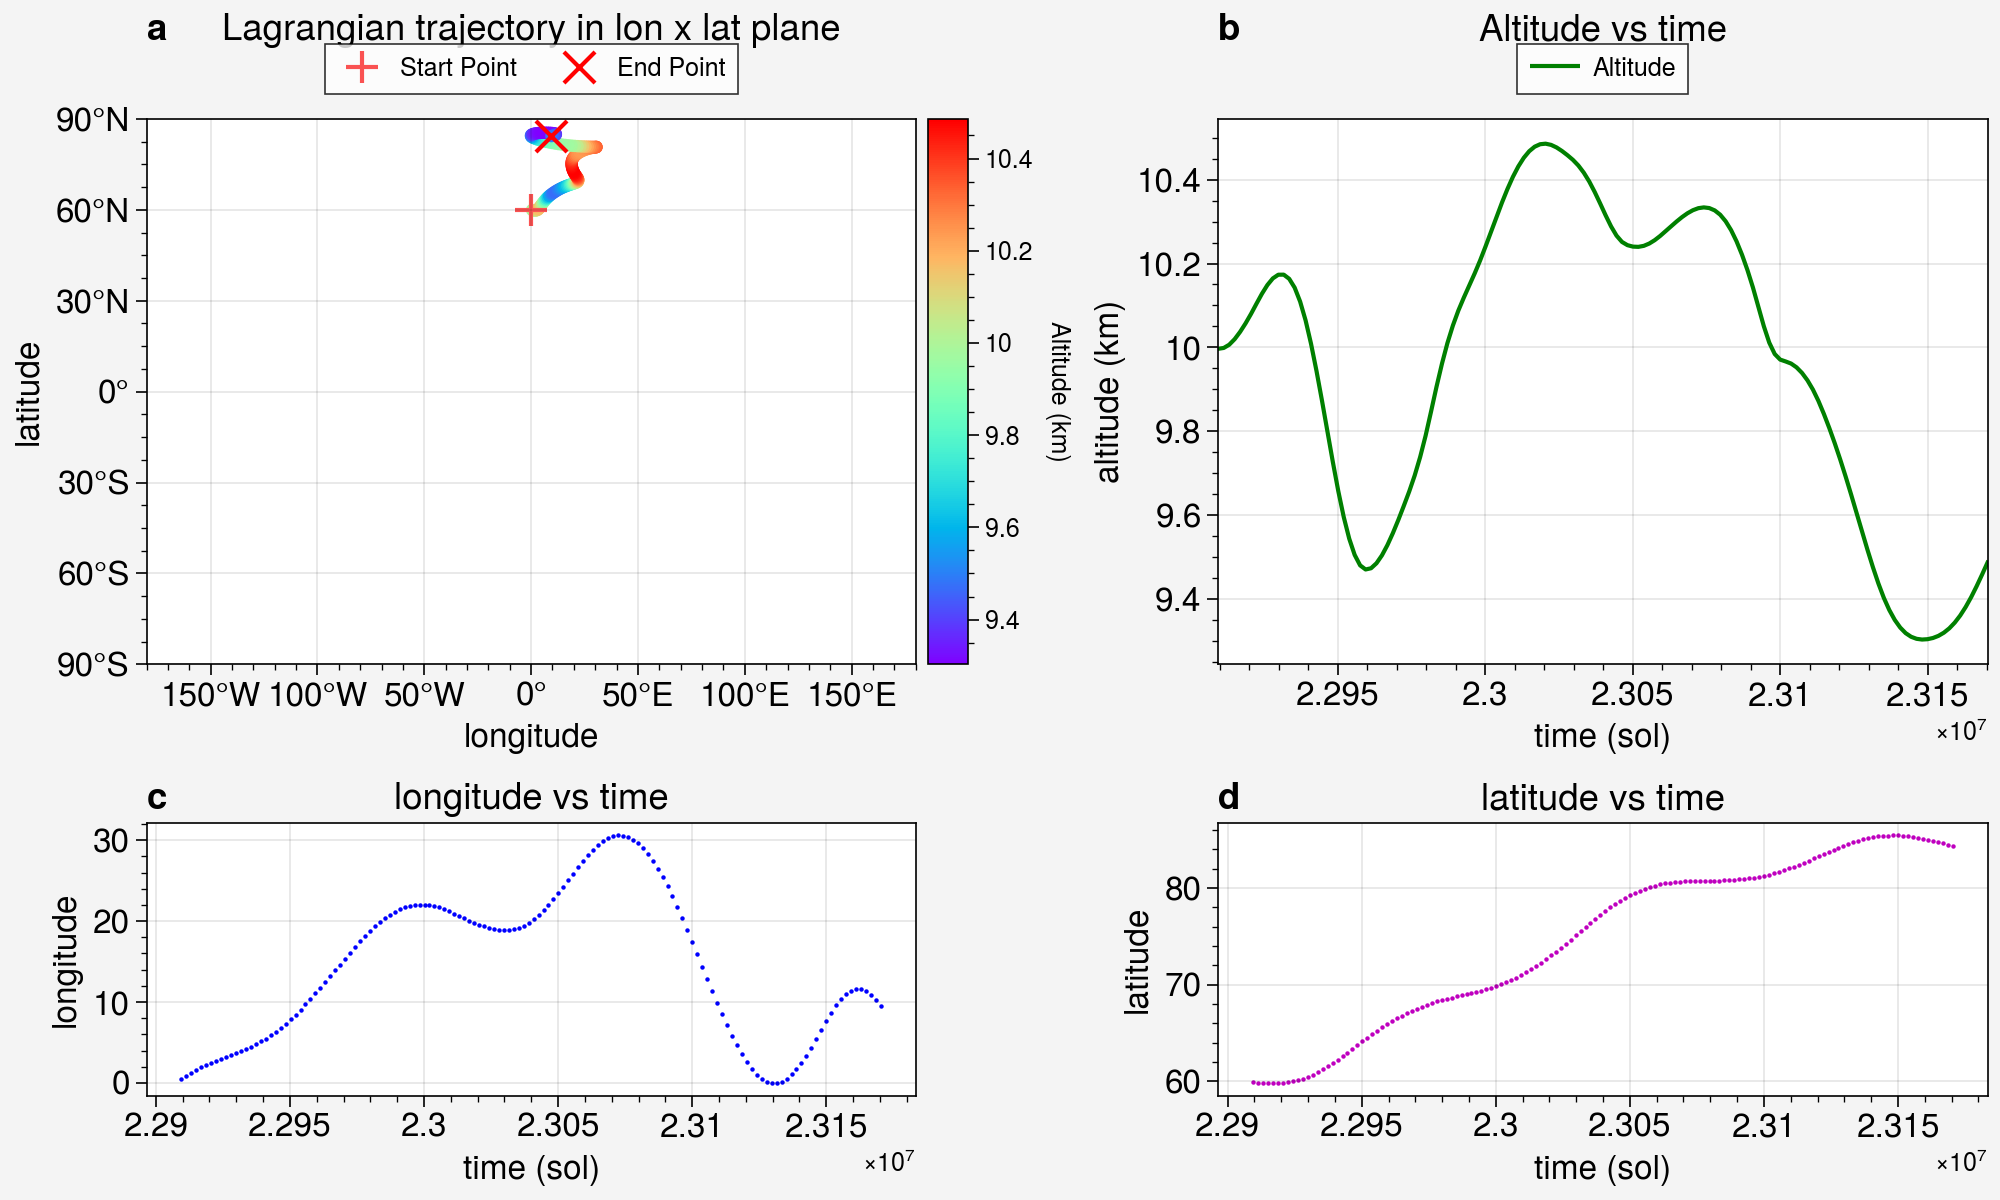

In [15]:
plot_trajectory(new_position_dict_list, start_points=None,time = trace_time)

In [16]:
final_dict = new_position_dict_list[-1]  # 最后一个时间步的结果：dict[(lon,lat,alt0)] -> (lonT,latT,altT)
seeds_back = [final_dict[pt] for pt in need_track_initial_points]  # [(lonT,latT,altT), ...]

new_position_dict_list_back = track_particles_heun_backward(
    new_time_points, u_time_interp, v_time_interp, w_time_interp,
    seeds_back,                      # 用前向末尾位置作为后向初始点
    alt, lat, lon,                  # 与前向一致的网格
    lower_boundary, upper_boundary, # m
    radius=3396200, verbose=False,
    w_positive_up=True,             # 与前向一致
    lon_mode=None,                  # 留空以自动推断（或按需显式设 '0_360'）
    start_time=new_time_points[-1]  # 从最后一个时间戳开始回放
)
trace_time_back = get_trace_time_heun_backward(
    new_time_points,
    start_time=new_time_points[-1]
)

100%|██████████| 142/142 [00:00<00:00, 236251.95it/s]


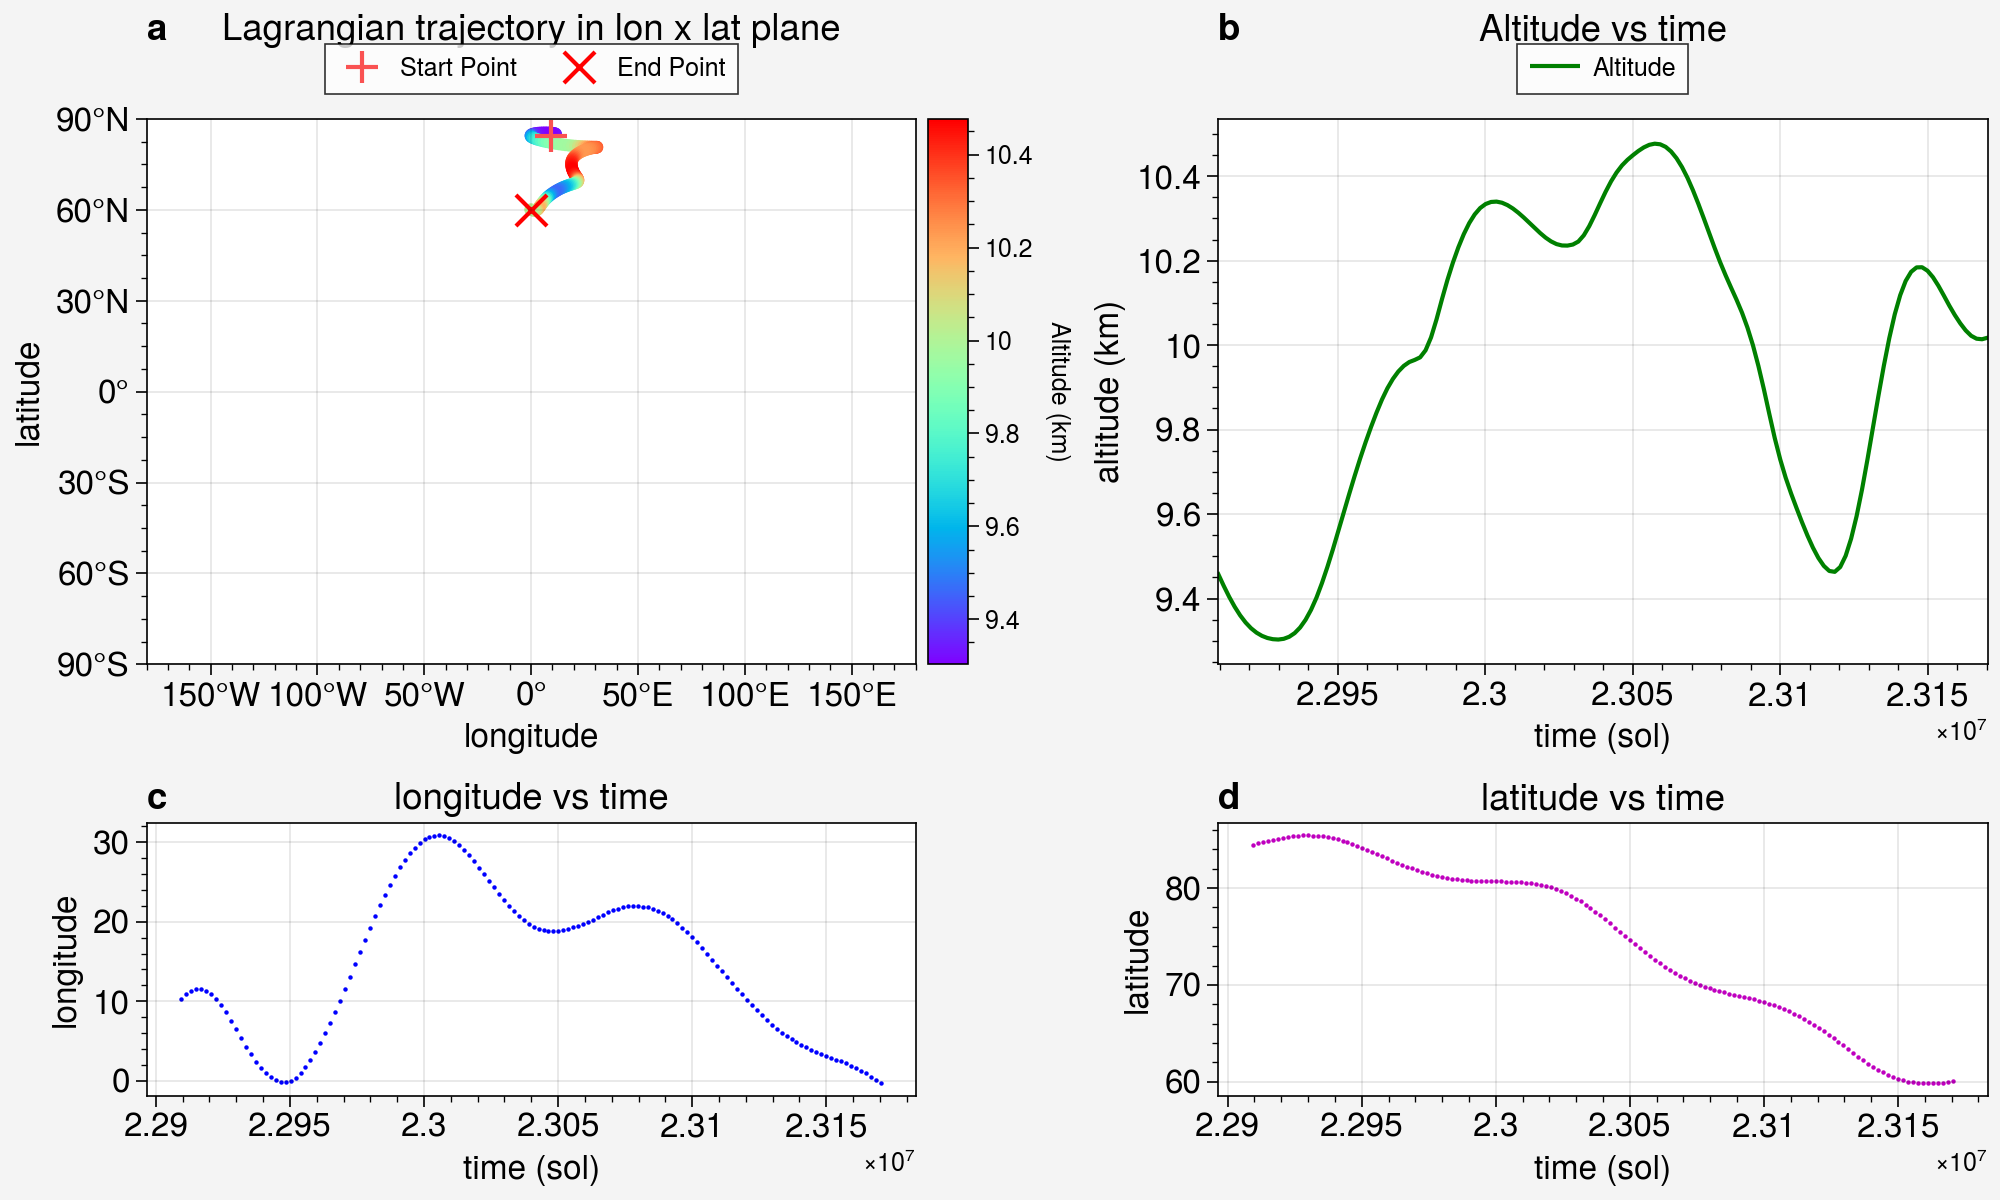

In [17]:
plot_trajectory(new_position_dict_list_back, start_points=None,time = trace_time)